# X3D (eXpanded 3D) Implementation - Design Alternative 1

`Warning:` Do not run all the code, read the notes first before running them as they may reduce your device's memory when not careful, leading to a kernel crash or Out-Of-Memory (OOM) Error, sige ka magla-lag yang pc mo

`Remarks`: Yeyyyyy panalo raw toh sa Sensiitivity Analysis

**Local System Specifications used to train the model:** <br>
| Component  | Device   |
| :------------- | :--------------- | 
| CPU   | AMD Ryzen 5 5600x     | 
| GPU   | Nvidia GeForce RTX 3070  8GB   | 
| RAM   | 32 GB     | 


`Note`: Implementation is taken from [Video classification with a 3D convolutional neural network](https://www.tensorflow.org/tutorials/video/video_classification)

## Create the dataset

#### Import Libraries and Configure Device

In [1]:
## Uncomment if you are running on colab

#!pip install keras-tuner imageio opencv-python tqdm seaborn scikit-learn
#!pip install -q git+https://github.com/tensorflow/docs

#!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF101/UCF101.rar
#!unrar x UCF101.rar

In [3]:
from tqdm import tqdm
import random
import pathlib
import itertools
import collections 
import os
import time

import shutil
import cv2
import mediapipe as mp
import einops
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, auc, average_precision_score

import torch
import torchvision.transforms as T
import json
import urllib
from pytorchvideo.data.encoded_video import EncodedVideo

#### Visualize the data first

In [4]:
def visulize_data(fil_dir):
    """ 
    Let's you visualize the video

    Args:
        fil_dir: Directory of files

    Returns:
        Plot of videos along with the labels

    """

    plt.figure(figsize=(20, 20))
    all_class_names = os.listdir(path=fil_dir)
    random_range = random.sample(range(len(all_class_names)),
                                  len(all_class_names)-random.randrange(1, len(all_class_names)))

    for counter, rand_idx in enumerate(random_range, 1):
        selected_class_name = all_class_names[rand_idx]
        video_files_names_list = os.listdir(f'{fil_dir}/{selected_class_name}')
        selected_video_file_name = random.choice(video_files_names_list)

        video_reader = cv2.VideoCapture(f'{fil_dir}/{selected_class_name}/{selected_video_file_name}')
        _, frame = video_reader.read()
        video_reader.release()

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        cv2.putText(rgb_frame, selected_class_name, (10,30), cv2.FONT_HERSHEY_DUPLEX, 1, (0,0,255), 2)

        plt.subplot(5, 4, counter)
        plt.imshow(rgb_frame)
        plt.axis('off')

#### Loading of dataset

In [5]:
## Define the dimensions of frames in the set of frames created (Default params muna)
HEIGHT = 224
WIDTH = 224
SEQUENCE_LENGTH = 24 # small frame raw para small memory at computation ang gawin, ndi kakakayanin ng mga nasa 16GB lang
LABELS = sorted(['BarbellCurl', 'Deadlift', 'Squat', 'LateralRaises', 'OverheadPress'
          ]) # Eto muna

- `Note`: This can be changed later on once model is okay

In [6]:
def split_dataset(dataset_dir, 
                  splits={"train": 0.7, "val": 0.15, "test": 0.15}, 
                  seed=42, 
                  selected_classes=None):
    """
    Split the video dataset into train, validation, and test sets and save to subdirectories.
    Ensures no data duplication across splits.
    """
    random.seed(seed)
    
    # Convert dataset directory to Path object
    dataset_dir = pathlib.Path(dataset_dir)
    splits_dirs = ["train", "val", "test"]

    # Remove existing split directories to avoid data overlap
    for split in splits_dirs:
        split_dir = dataset_dir / split
        if split_dir.exists():
            shutil.rmtree(split_dir)

    # Iterate over each class folder in the dataset
    class_dirs = [f for f in dataset_dir.iterdir() if f.is_dir()]
    
    # Filter classes if `selected_classes` is provided
    if selected_classes:
        class_dirs = [f for f in class_dirs if f.name in selected_classes]
    
    for class_dir in tqdm(class_dirs, desc="Processing classes", unit="class"): # May loading yan :)
        print(f"\nProcessing class: {class_dir.name}")
        
        # Get a list of video files in the class directory
        video_files = [f for f in class_dir.iterdir() if f.is_file()]
        
        random.shuffle(video_files)
        
        num_videos = len(video_files)
        train_end = int(splits["train"] * num_videos)
        val_end = train_end + int(splits["val"] * num_videos)
        
        # Split the video files into train, val, and test 
        train_files = video_files[:train_end]
        val_files = video_files[train_end:val_end]
        test_files = video_files[val_end:]
        
        # Move files to directories (tran, val, test)
        for split, files in zip(splits_dirs, [train_files, val_files, test_files]):
            split_dir = dataset_dir / split / class_dir.name
            split_dir.mkdir(parents=True, exist_ok=True)  # Create the class folder in the split directory
            
            for file in tqdm(files, desc=f"Moving files to {split}/{class_dir.name}", unit="file"):
                shutil.move(str(file), str(split_dir / file.name))
    
    print("\nDataset split complete!")

In [7]:
## File path
file_path = './Workout/' 

In [8]:
## Split the dataset, if na-run na ng isang beses wag na i-run ule, dahil sa code na hindi pa naayos, mawawala lahat yan since na split na si dataset
#split_dataset(file_path, splits={"train": 0.7, "val": 0.15, "test": 0.15}, selected_classes=LABELS) 

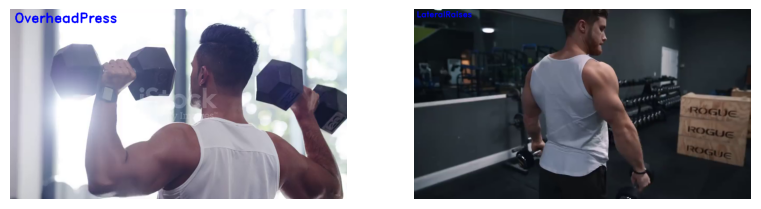

In [9]:
visulize_data(file_path + 'train/')

In [10]:
## Creates a path to the dataset
dataset_paths = {'train':pathlib.PosixPath(f'{file_path}train'),
                    'val':pathlib.PosixPath(f'{file_path}val'),
                    'test':pathlib.PosixPath(f'{file_path}test')}

#### Create Frames from each video

In [11]:
def format_frames(frame, output_size):
    """
    Pad and resize an image from a video.
    
    Args:
        frame (numpy.ndarray): Image to be resized and padded.
        output_size (tuple): Pixel size of the output frame image.

    Returns:
        torch.Tensor: Formatted frame with padding of specified output size.
    """
    transform = T.Compose([
        T.ToPILImage(),
        T.Resize(output_size),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to range [-1, 1]
    ])
    return transform(frame)

In [12]:
def frames_from_video_file(video_path, n_frames, output_size=(224, 224)):
    result = []
    src = cv2.VideoCapture(str(video_path))
    video_length = int(src.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = max(1, video_length // n_frames)

    if video_length <= n_frames:
        start = 0
    else:
        max_start = video_length - n_frames * frame_step
        start = np.random.randint(0, max_start)

    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    if ret:
        result.append(format_frames(frame, output_size))

    for _ in range(n_frames - 1):
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            result.append(format_frames(frame, output_size))
        else:
            result.append(torch.zeros_like(result[0]))

    src.release()
    result = torch.stack(result)
    return result.permute(0, 3, 1, 2)  # Convert to [N, C, H, W]

In [13]:
def augment_frames(frames):
    """
    Augment frames with random transformations.
    
    Args:
        frames (torch.Tensor): Frames to augment. Shape: [N, C, H, W].
        
    Returns:
        torch.Tensor: Augmented frames.
    """
    transform = T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
    ])
    augmented_frames = [transform(frame) for frame in frames]
    return torch.stack(augmented_frames)

In [14]:
from torch.utils.data import Dataset

class FrameGenerator(Dataset):
    def __init__(self, path, n_frames, training=False, augment=False):
        self.path = path
        self.n_frames = n_frames
        self.training = training
        self.augment = augment
        self.class_names = sorted([p.name for p in path.iterdir() if p.is_dir()])
        self.class_ids_for_name = {name: idx for idx, name in enumerate(self.class_names)}
        self.video_paths, self.classes = self.get_files_and_class_names()

    def get_files_and_class_names(self):
        video_paths = list(self.path.glob('*/*.avi')) + list(self.path.glob('*/*.mov')) + list(self.path.glob('*/*.mp4'))
        classes = [p.parent.name for p in video_paths]
        return video_paths, classes

    def __len__(self):
        return len(self.video_paths)

    def __getitem__(self, idx):
        video_path = self.video_paths[idx]
        class_name = self.classes[idx]
        label = self.class_ids_for_name[class_name]
        video_frames = frames_from_video_file(video_path, self.n_frames, output_size=(224, 224))
        
        if self.augment and self.training:
            video_frames = augment_frames(video_frames)

        return video_frames, label

In [15]:
from torch.utils.data import DataLoader

def configure_dataset(dataset_path, n_frames, batch_size=2, training=False, augment=False):
    dataset = FrameGenerator(dataset_path, n_frames, training=training, augment=augment)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=training,
        num_workers=4,
        pin_memory=True
    )
    return loader

#### Split and Generate the datasets

In [17]:
train_ds = configure_dataset(dataset_paths['train'], SEQUENCE_LENGTH, training=True, augment=True)

# Create the training set
for train_frames, train_labels in train_ds:
    print(train_frames.shape, train_labels)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/mnt/d/vscodeProjects/wintorch/lib/python3.12/site-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/vscodeProjects/wintorch/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_39226/1336478681.py", line 28, in __getitem__
    video_frames = augment_frames(video_frames)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_39226/4155219128.py", line 15, in augment_frames
    augmented_frames = [transform(frame) for frame in frames]
                        ^^^^^^^^^^^^^^^^
  File "/mnt/d/vscodeProjects/wintorch/lib/python3.12/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
          ^^^^^^
  File "/mnt/d/vscodeProjects/wintorch/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/vscodeProjects/wintorch/lib/python3.12/site-packages/torch/nn/modules/module.py", line 1747, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/vscodeProjects/wintorch/lib/python3.12/site-packages/torchvision/transforms/transforms.py", line 1274, in forward
    img = F.adjust_brightness(img, brightness_factor)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/vscodeProjects/wintorch/lib/python3.12/site-packages/torchvision/transforms/functional.py", line 887, in adjust_brightness
    return F_t.adjust_brightness(img, brightness_factor)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/mnt/d/vscodeProjects/wintorch/lib/python3.12/site-packages/torchvision/transforms/_functional_tensor.py", line 177, in adjust_brightness
    _assert_channels(img, [1, 3])
  File "/mnt/d/vscodeProjects/wintorch/lib/python3.12/site-packages/torchvision/transforms/_functional_tensor.py", line 63, in _assert_channels
    raise TypeError(f"Input image tensor permitted channel values are {permitted}, but found {c}")
TypeError: Input image tensor permitted channel values are [1, 3], but found 224


In [17]:
val_ds = configure_dataset(dataset_paths['val'], SEQUENCE_LENGTH, training=False)

# Create the training set
val_frames, val_labels = next(iter(val_ds))
print(f'Shape of training set of frames: {val_frames.shape}')
print(f'Shape of training labels: {val_labels.shape}')

Shape of training set of frames: (2, 18, 128, 128, 3)
Shape of training labels: (2,)


- `Note`: Datasets can be configured to increase performance when loading and training it in a model, this is called *prefetch*. The *prefetch* is efficient when loading the dataset in the memory, making it faster; it also helps with utilizing the GPU, making it train faster.

#### Plotting Functions for later

In [ ]:
def plot_history(train_loss, val_loss, train_acc, val_acc):
    """
        Plotting training and validation learning curves.
        Args: 
         history: model history with all the metric measures
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18.5, 10.5))

    # Loss plot
    ax1.plot(train_loss, label="Train Loss")
    ax1.plot(val_loss, label="Validation Loss")
    ax1.set_title("Loss")
    ax1.set_ylabel("Loss")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    # Accuracy plot
    ax2.plot(train_acc, label="Train Accuracy")
    ax2.plot(val_acc, label="Validation Accuracy")
    ax2.set_title("Accuracy")
    ax2.set_ylabel("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    plt.show()

In [ ]:
def get_actual_predicted_labels(dataloader, trained_model, device='cuda'):
    """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
        dataloader: An iterable data loader with features and labels.
        trained_model: The trained PyTorch model.
        device: The device to run the model on ('cuda' or 'cpu').

    Returns:
        actual (torch.Tensor): Ground truth labels.
        predicted (torch.Tensor): Predicted labels.
    """
    actual = []
    predicted = []

    trained_model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Get predictions
            outputs = trained_model(inputs)
            preds = torch.argmax(outputs, dim=1)
            
            # Collect ground truth and predictions
            actual.append(labels)
            predicted.append(preds)

    # Concatenate all batches into single tensors
    actual = torch.cat(actual, dim=0)
    predicted = torch.cat(predicted, dim=0)

    return actual, predicted



def plot_confusion_matrix(y_actual, y_pred, labels, ds_type):
    """
    Plot a confusion matrix.

    Args:
        y_actual (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
        labels (list): List of class names.
        ds_type (str): Type of dataset (e.g., "Train", "Validation").

    Returns:
        None: Displays the confusion matrix plot.
    """
    cm = confusion_matrix(y_actual, y_pred)
    plt.figure(figsize=(12, 12))
    ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)
    ax.set_title(f'Confusion Matrix for {ds_type}')
    ax.set_xlabel('Predicted Action')
    ax.set_ylabel('Actual Action')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

In [ ]:
def calculate_classification_metrics(y_actual, y_pred, labels):
    """
    Calculate precision, recall, and F1-score for each class.

    Args:
        y_actual (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
        labels (list): List of class names.

    Returns:
        dict: Dictionary containing precision, recall, and F1-score per class.
    """
    report = classification_report(y_actual, y_pred, target_names=labels, output_dict=True)
    precision = {label: report[label]['precision'] for label in labels}
    recall = {label: report[label]['recall'] for label in labels}
    f1_scores = {label: report[label]['f1-score'] for label in labels}
    return precision, recall, f1_scores

In [ ]:
def calculate_f1_score(y_actual, y_pred, labels, average='macro'):
    """
    Calculate F1-Score for each class and optionally a macro-average.

    Args:
        y_actual (list or array): Ground truth labels.
        y_pred (list or array): Predicted labels.
        labels (list): List of class names.
        average (str): 'macro' to return average F1-score, 'none' for per-class F1-scores.

    Returns:
        dict: F1-scores per class and/or macro-average F1-score.
    """
    cm = confusion_matrix(y_actual, y_pred, labels=range(len(labels)))
    tp = np.diag(cm)  # True positives (diagonal elements)
    precision = tp / (np.sum(cm, axis=0) + 1e-7)  # Avoid division by zero
    recall = tp / (np.sum(cm, axis=1) + 1e-7)

    f1_scores = {label: 2 * (precision[i] * recall[i]) / (precision[i] + recall[i] + 1e-7)
                 for i, label in enumerate(labels)}

    if average == 'macro':
        macro_f1 = np.mean(list(f1_scores.values()))
        return f1_scores, macro_f1

    return f1_scores

In [ ]:
def calculate_map(y_actual, y_pred, num_classes):
    """
    Calculate Mean Average Precision (mAP) for multi-class classification.

    Args:
        y_actual (list or array): Ground truth labels (class indices).
        y_pred (numpy.ndarray): Predicted probabilities (e.g., softmax outputs from the model).
        num_classes (int): Number of classes in the dataset.

    Returns:
        float: Mean Average Precision score.
    """
    y_actual_one_hot = np.eye(num_classes)[y_actual]  # Convert to one-hot
    aps = []
    for i in range(num_classes):
        ap = average_precision_score(y_actual_one_hot[:, i], y_pred[:, i])
        aps.append(ap)

    return np.mean(aps)

In [ ]:
def plot_precision_recall_curve(y_actual, y_pred, labels):
    """
    Plot Precision-Recall curves and calculate AUC for each class.

    Args:
        y_actual (list or array): Ground truth labels (class indices).
        y_pred (numpy.ndarray): Predicted probabilities (e.g., softmax outputs from the model).
        labels (list): List of class names.

    Returns:
        dict: Dictionary containing AUC-PR for each class.
    """
    auc_scores = {}
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(labels):
        # Create binary ground truth for the current class
        y_binary = (np.array(y_actual) == i).astype(int)
        precision, recall, _ = precision_recall_curve(y_binary, y_pred[:, i])
        pr_auc = auc(recall, precision)
        auc_scores[label] = pr_auc

        # Plot the precision-recall curve
        plt.plot(recall, precision, label=f'{label} (AUC = {pr_auc:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

    return auc_scores

## Model Structuring, HyperTuning, and Training

This Network Architecture is from the paper [X3D: Expanding Architectures for Efficient Video Recognition](https://arxiv.org/abs/2004.04730)

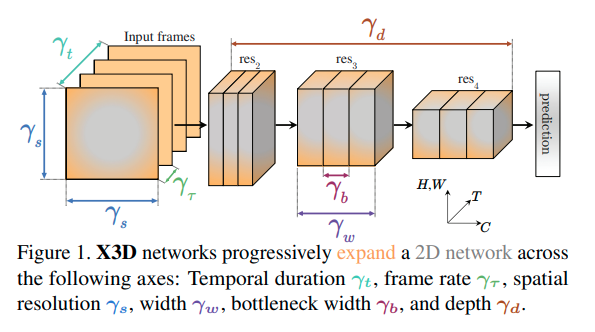

- `Note`: The structure of the is based on the figure above, it will be modified to tailor our project design's specific objectives

#### Network Building and HyperTuning of Parameters

In [ ]:
model_name = 'x3d_l'
model = torch.hub.load('facebookresearch/pytorchvideo', model_name, pretrained=False)

In [ ]:
class X3D(kt.HyperModel):
    def __init__(self, num_classes, sequence_length, shape):
        self.num_classes = num_classes
        self.input_shape = (None, sequence_length, shape[0], shape[1], 3)

    def build(self, hp):
        inputs = layers.Input(shape=self.input_shape[1:])
        x = inputs

        # Base Conv Layer
        base_filters = hp.Choice('base_filters', values=[16, 24, 32])
        x = layers.Conv3D(
            base_filters, kernel_size=(5, 7, 7), strides=(1, 2, 2), padding='same', kernel_initializer='he_normal'
        )(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.MaxPooling3D(pool_size=(1, 3, 3), strides=(1, 2, 2), padding='same')(x)

        # Stacked Bottleneck Blocks
        filters = base_filters
        for stage in range(6):  # 4 stages
            num_blocks = hp.Int(f'num_blocks_stage{stage + 1}', min_value=1, max_value=3, step=1)
            for block in range(num_blocks):
                strides = (1, 2, 2) if block == 0 and stage > 0 else (1, 1, 1)
                x = X3DBottleneck(filters, strides=strides)(x)

                # Add SEBlock conditionally
                if hp.Boolean('use_seblock'):
                    x = SEBlock(filters)(x)
            
            x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.05))(x)
            filters *= 2  # Double filters after each stage

        # Global Head
        x = layers.GlobalAveragePooling3D()(x)
        x = layers.Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu', kernel_initializer='he_normal')(x)
        x = layers.Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.4, step=0.05))(x)
        outputs = layers.Dense(self.num_classes)(x)  # Logits output, kaya no softmax activation

        # Compile the model
        lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
        optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
        if optimizer_choice == 'adam':
            optimizer = keras.optimizers.Adam(learning_rate=lr, clipnorm=1.0)
        else:
            optimizer = keras.optimizers.RMSprop(learning_rate=lr, rho=0.9, epsilon=1e-7, centered=False)

        model = keras.Model(inputs, outputs)
        model.compile(
            optimizer=optimizer,
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy']
        )

        return model

In [ ]:
## Tuner initislization
tuner = kt.BayesianOptimization(
    hypermodel=X3D(len(LABELS), SEQUENCE_LENGTH, (HEIGHT, WIDTH)),
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter configurations to try, adjust na lang toh sa pag paganda
    executions_per_trial=2,  # Average over multiple runs
    directory='X3D',
    project_name='model_tuning'
)

Reloading Tuner from X3D/model_tuning/tuner0.json


In [ ]:
tuner.search(train_ds, validation_data=val_ds, epochs=15)

Trial 5 Complete [00h 09m 19s]
val_accuracy: 0.23780488222837448

Best val_accuracy So Far: 0.5548780560493469
Total elapsed time: 01h 42m 09s


In [28]:
hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]
model_1 = tuner.hypermodel.build(hyperparams)

In [29]:
frames, label = next(iter(train_ds))
model_1.build(frames)
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 18, 128, 128,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_33 (Conv3D)              │ (None, 18, 64, 64, 32) │        23,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 18, 64, 64, 32) │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_25 (ReLU)                 │ (None, 18, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 18, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_8                │ (None, 18, 32, 32, 32) │        31,360 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_8 (SEBlock)            │ (None, 18, 32, 32, 32) │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_9                │ (None, 18, 32, 32, 32) │        31,360 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_9 (SEBlock)            │ (None, 18, 32, 32, 32) │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_10               │ (None, 18, 32, 32, 32) │        31,360 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_10 (SEBlock)           │ (None, 18, 32, 32, 32) │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 18, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_11               │ (None, 18, 16, 16, 64) │       120,064 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_11 (SEBlock)           │ (None, 18, 16, 16, 64) │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_12               │ (None, 18, 16, 16, 64) │       124,160 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_12 (SEBlock)           │ (None, 18, 16, 16, 64) │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 18, 16, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_13               │ (None, 18, 8, 8, 128)  │       477,696 │
│ (X3DBottleneck)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ se_block_13 (SEBlock)           │ (None, 18, 8, 8, 128)  │         2,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 18, 8, 8, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x3d_bottleneck_14               │ (None, 18, 4, 4, 256)  │     1,905,66

 Total params: 6,851,115 (26.13 MB)

 Trainable params: 6,842,091 (26.10 MB)

 Non-trainable params: 9,024 (35.25 KB)

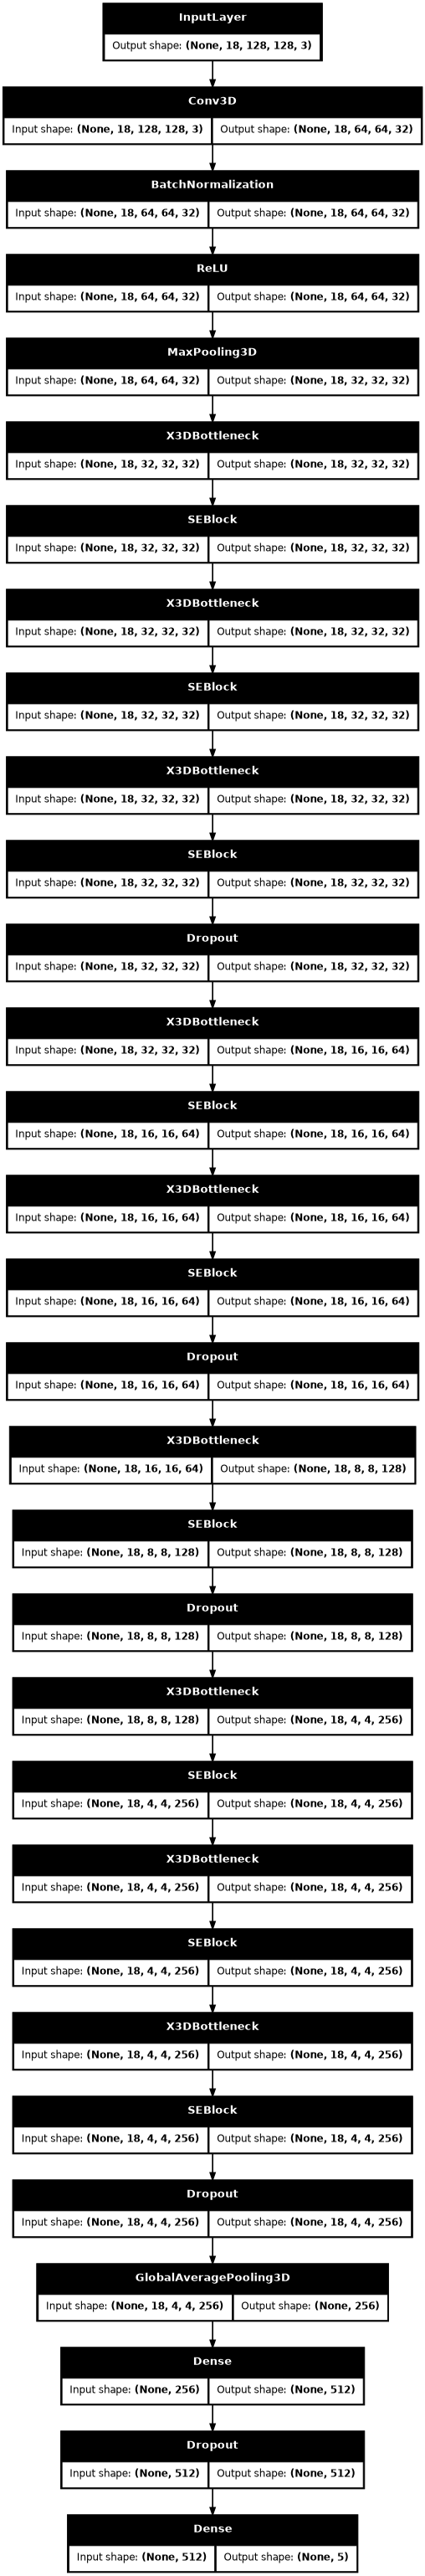

In [30]:
# Visualize the model
keras.utils.plot_model(model_1, expand_nested=True, dpi=60, show_shapes=True)

#### Train the model

In [ ]:
# Create a callback that saves the model's weights while training
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_X3D.keras',       
    save_weights_only=False,           
    save_best_only=True,                
    monitor='val_loss',                 
    mode='min',                         
)

early_stopping_model = keras.callbacks.EarlyStopping(
    monitor='val_loss',        
    patience=15,                
    min_delta=1e-4,            
    restore_best_weights=True  
)

In [32]:
start_time = time.time()

history_1 = model_1.fit(x = train_ds,
                    epochs = 300, # You can change this if you want, ikaw bahala
                    callbacks=[checkpoint, early_stopping_model],
                    validation_data = val_ds)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Total training time: {elapsed_time // 60:.0f} minutes and {elapsed_time % 60:.2f} seconds")

Epoch 1/300
    194/Unknown 43s 26ms/step - accuracy: 0.2157 - loss: 1.7380

2024-12-01 18:25:13.261903: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[64,64,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,18,16,16]{4,3,2,1,0}, f32[1,64,18,16,16]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-01 18:25:13.266562: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.950043992s
Trying algorithm eng0{} for conv (f32[64,64,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[1,64,18,16,16]{4,3,2,1,0}, f32[1,64,18,16,16]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config=

    196/Unknown 61s 118ms/step - accuracy: 0.2159 - loss: 1.7374

/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-12-01 18:25:42.330065: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11354110518576023595
2024-12-01 18:25:42.330110: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1588066703722116545


196/196 ━━━━━━━━━━━━━━━━━━━━ 83s 230ms/step - accuracy: 0.2159 - loss: 1.7371 - val_accuracy: 0.1951 - val_loss: 1.8264
Epoch 2/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 29s 147ms/step - accuracy: 0.2609 - loss: 1.5445 - val_accuracy: 0.3293 - val_loss: 1.4277
Epoch 3/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - accuracy: 0.4012 - loss: 1.4201 - val_accuracy: 0.4268 - val_loss: 1.2501
Epoch 4/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.3510 - loss: 1.4690 - val_accuracy: 0.3780 - val_loss: 1.4812
Epoch 5/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.4085 - loss: 1.3553 - val_accuracy: 0.5244 - val_loss: 1.1842
Epoch 6/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - accuracy: 0.4482 - loss: 1.2797 - val_accuracy: 0.4268 - val_loss: 1.4704
Epoch 7/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.4452 - loss: 1.2966 - val_accuracy: 0.3902 - val_loss: 1.6195
Epoch 8/300
  1/196 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step - accuracy: 0.5000 - loss: 1.627

2024-12-01 18:28:24.899676: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11354110518576023595
2024-12-01 18:28:24.899725: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1588066703722116545


196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - accuracy: 0.4971 - loss: 1.1716 - val_accuracy: 0.4756 - val_loss: 1.1799
Epoch 9/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - accuracy: 0.4997 - loss: 1.1363 - val_accuracy: 0.5244 - val_loss: 1.1643
Epoch 10/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 24s 120ms/step - accuracy: 0.6147 - loss: 1.0079 - val_accuracy: 0.5732 - val_loss: 1.2110
Epoch 11/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.5839 - loss: 0.9910 - val_accuracy: 0.5366 - val_loss: 1.1533
Epoch 12/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 134ms/step - accuracy: 0.6999 - loss: 0.9056 - val_accuracy: 0.4390 - val_loss: 1.2854
Epoch 13/300
  1/196 ━━━━━━━━━━━━━━━━━━━━ 22s 115ms/step - accuracy: 0.5000 - loss: 1.3656

2024-12-01 18:30:38.547220: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.7242 - loss: 0.7554 - val_accuracy: 0.5488 - val_loss: 1.2419
Epoch 14/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.7815 - loss: 0.6274 - val_accuracy: 0.5854 - val_loss: 1.3722
Epoch 15/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.7165 - loss: 0.6885 - val_accuracy: 0.5732 - val_loss: 1.3300
Epoch 16/300
  1/196 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 1.0000 - loss: 0.3468

2024-12-01 18:31:54.478010: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11354110518576023595
2024-12-01 18:31:54.478045: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1588066703722116545


196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.8396 - loss: 0.5104 - val_accuracy: 0.5122 - val_loss: 1.5620
Epoch 17/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.8147 - loss: 0.4868 - val_accuracy: 0.6098 - val_loss: 1.0433
Epoch 18/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 132ms/step - accuracy: 0.8856 - loss: 0.3433 - val_accuracy: 0.5732 - val_loss: 1.4253
Epoch 19/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 133ms/step - accuracy: 0.8668 - loss: 0.3314 - val_accuracy: 0.6585 - val_loss: 1.1009
Epoch 20/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.9575 - loss: 0.1591 - val_accuracy: 0.5854 - val_loss: 1.3315
Epoch 21/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 117ms/step - accuracy: 0.9678 - loss: 0.1194 - val_accuracy: 0.5976 - val_loss: 1.2777
Epoch 22/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9599 - loss: 0.1449 - val_accuracy: 0.6341 - val_loss: 1.7692
Epoch 23/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.9633 - loss

2024-12-01 18:36:11.817943: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11354110518576023595
2024-12-01 18:36:11.817989: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1588066703722116545


196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - accuracy: 0.9783 - loss: 0.0818 - val_accuracy: 0.5854 - val_loss: 1.6937
Epoch 27/300
  1/196 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 1.0000 - loss: 0.0056

2024-12-01 18:36:38.421591: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11354110518576023595
2024-12-01 18:36:38.421641: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1588066703722116545


196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.9870 - loss: 0.0243 - val_accuracy: 0.5976 - val_loss: 1.6553
Epoch 28/300
  1/196 ━━━━━━━━━━━━━━━━━━━━ 28s 147ms/step - accuracy: 1.0000 - loss: 3.9580e-04

2024-12-01 18:37:04.968817: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11354110518576023595
2024-12-01 18:37:04.968873: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1588066703722116545


196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 118ms/step - accuracy: 0.9858 - loss: 0.0555 - val_accuracy: 0.5488 - val_loss: 2.1793
Epoch 29/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - accuracy: 0.9866 - loss: 0.0457 - val_accuracy: 0.5366 - val_loss: 2.4044
Epoch 30/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 140ms/step - accuracy: 0.9464 - loss: 0.1714 - val_accuracy: 0.6951 - val_loss: 1.6302
Epoch 31/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 27s 137ms/step - accuracy: 0.9787 - loss: 0.0339 - val_accuracy: 0.6220 - val_loss: 2.6507
Epoch 32/300
196/196 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.9850 - loss: 0.0367 - val_accuracy: 0.5732 - val_loss: 2.3010
Total training time: 14 minutes and 50.95 seconds


- `Remarks`: Why use more than 100 epochs you ask? Because some [Indian guy on YouTube](https://youtu.be/QmtSkq3DYko?si=V28jCOfot8MeHep6) used 500 epochs to train his Action Recognition model, therefore it is also wise to use the same training scheme. What a chad!

#### Plot the model and get the metrics

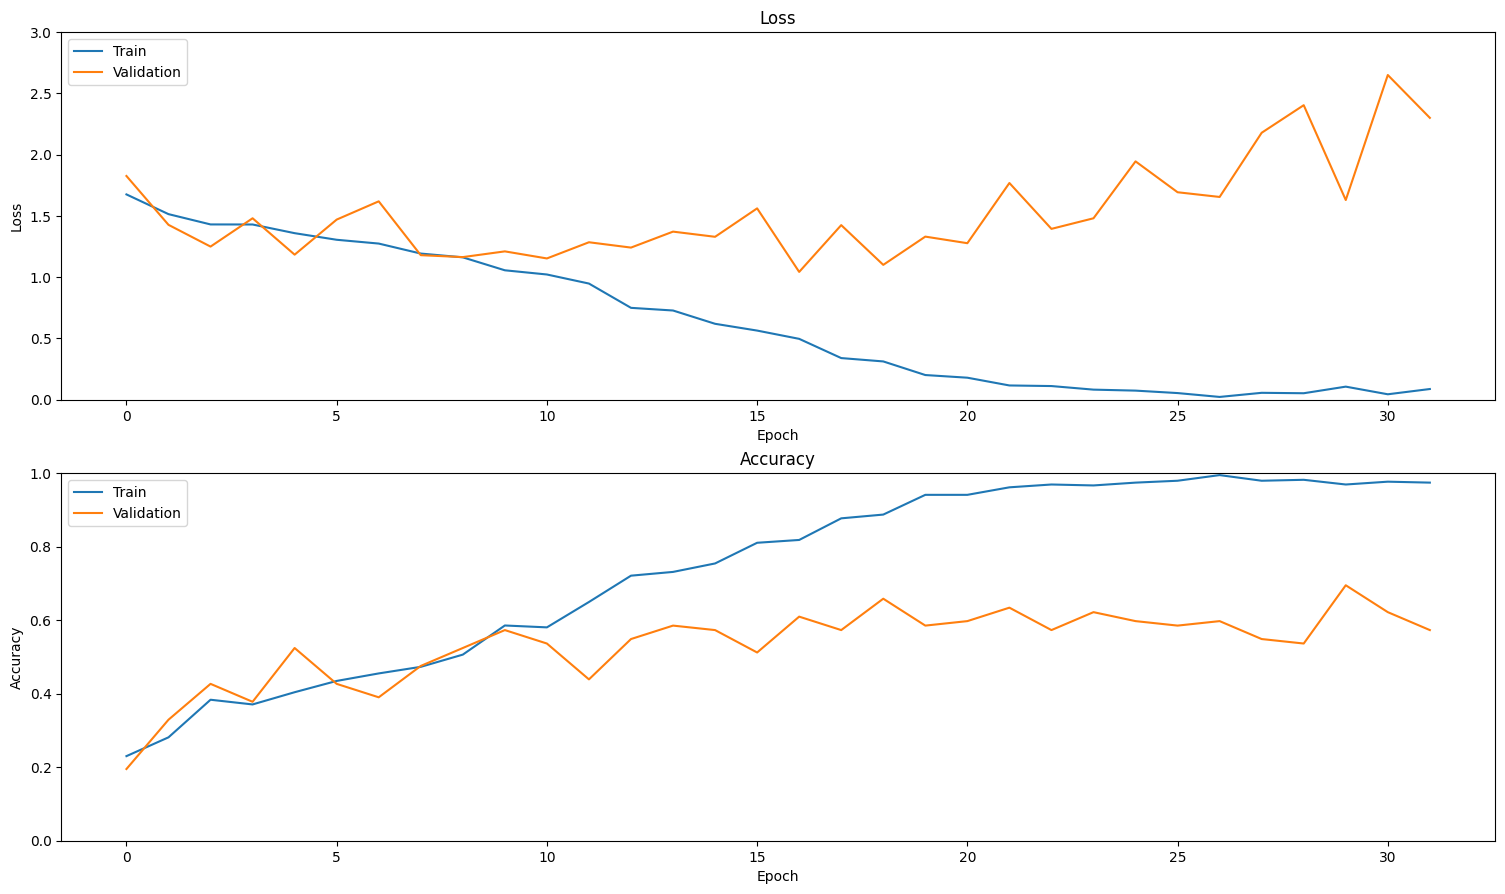

In [33]:
plot_history(history_1)

In [34]:
test_ds = configure_dataset(dataset_paths['test'], SEQUENCE_LENGTH, training=False)

# Create the training set
test_frames, test_labels = next(iter(test_ds))
print(f'Shape of validating set of frames: {test_frames.shape}')
print(f'Shape of validating labels: {test_labels.shape}')

Shape of validating set of frames: (2, 18, 128, 128, 3)
Shape of validating labels: (2,)


In [35]:
model_1.evaluate(test_ds, return_dict=True)

44/44 ━━━━━━━━━━━━━━━━━━━━ 31s 702ms/step - accuracy: 0.5265 - loss: 1.2765


{'accuracy': 0.5681818127632141, 'loss': 1.2228718996047974}

In [36]:
fg = FrameGenerator(dataset_paths['train'], SEQUENCE_LENGTH, training=True)
labels = list(fg.class_ids_for_name.keys())

196/196 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


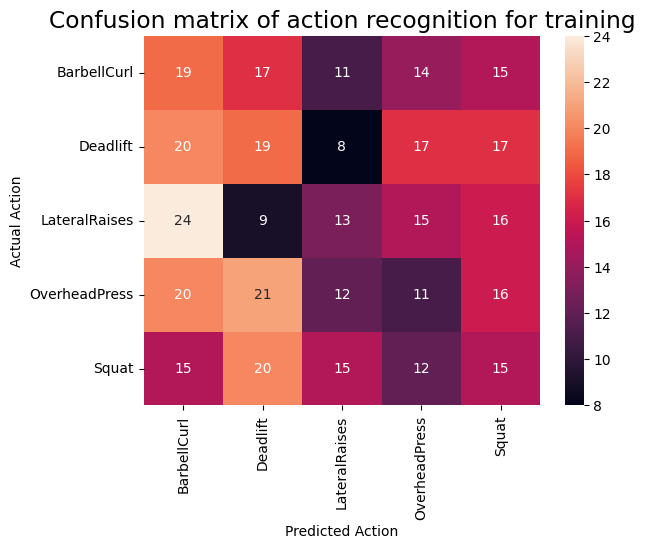

In [37]:
actual, predicted = get_actual_predicted_labels(train_ds, model_1)
plot_confusion_matrix(actual, predicted, labels, 'training')

44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 632ms/step


/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


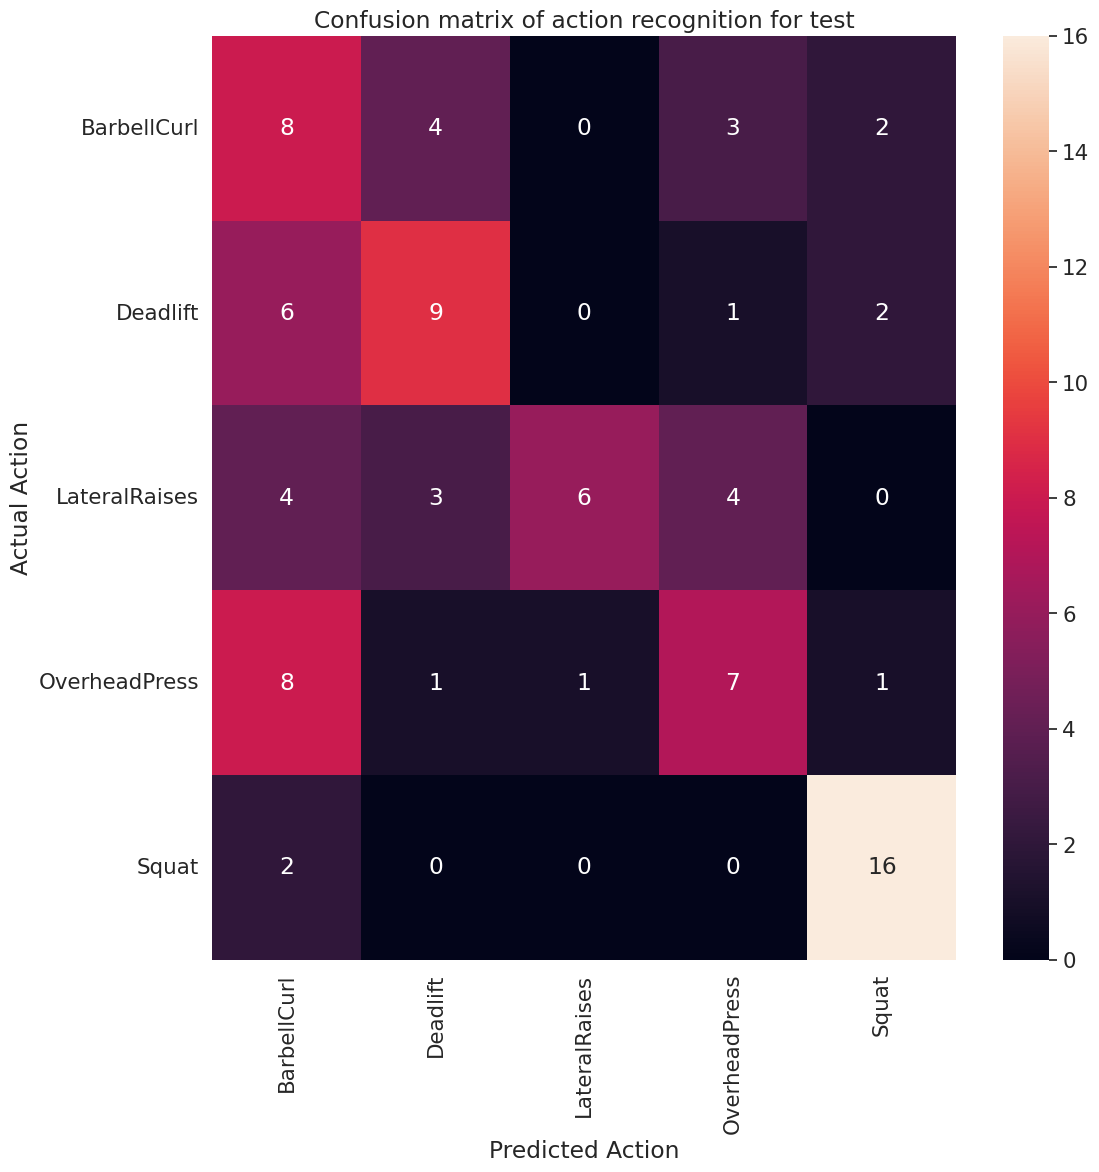

In [38]:
actual, predicted = get_actual_predicted_labels(test_ds, model_1)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [39]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [40]:
precision

{'BarbellCurl': 0.2857142857142857,
 'Deadlift': 0.5294117647058824,
 'LateralRaises': 0.8571428571428571,
 'OverheadPress': 0.4666666666666667,
 'Squat': 0.7619047619047619}

In [41]:
recall

{'BarbellCurl': 0.47058823529411764,
 'Deadlift': 0.5,
 'LateralRaises': 0.35294117647058826,
 'OverheadPress': 0.3888888888888889,
 'Squat': 0.8888888888888888}

## Load Model and Test

In [42]:
## Load model
load_model = keras.models.load_model('model_X3D.keras',
                                    custom_objects={'SEBlock': SEBlock,
                                                    'X3DBottleneck': X3DBottleneck,
                                                    })

/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'x3d_bottleneck_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'se_block_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/mnt/d/vscodeProjects/wincuda/lib/python3.12/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` w

#### Evaluate the Model

In [43]:
actual, predicted = get_actual_predicted_labels(test_ds, load_model)

44/44 ━━━━━━━━━━━━━━━━━━━━ 30s 640ms/step


/usr/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


In [44]:
f1_score = calculate_f1_score(actual, predicted, labels)
f1_score[1]

0.528369960099712

In [45]:
proba = load_model.predict(test_ds)

44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 645ms/step


In [46]:
MAP = calculate_map(actual, proba, len(labels))
MAP

0.5862021658247715

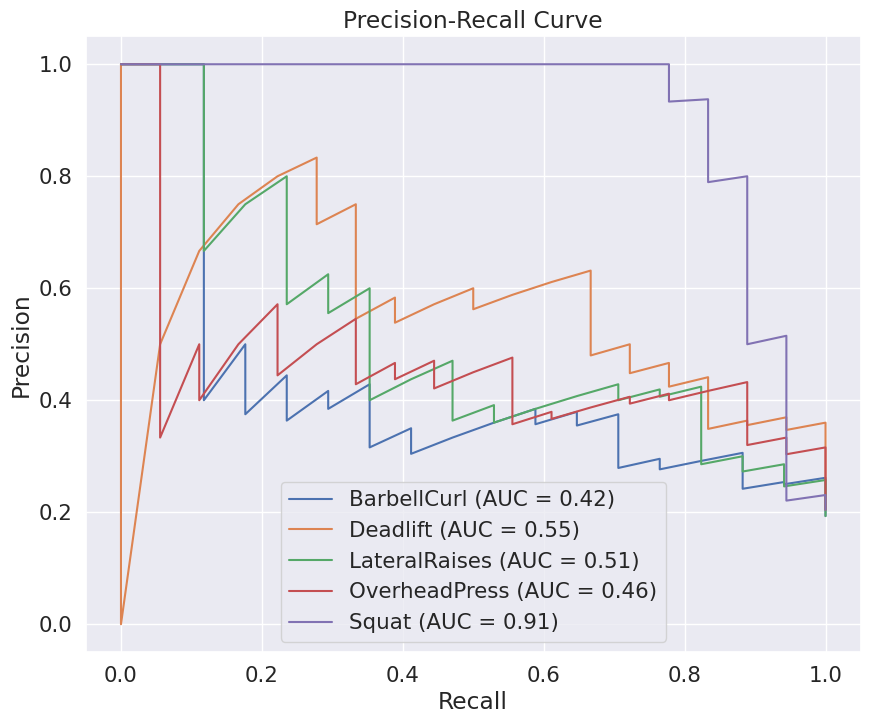

{'BarbellCurl': 0.4196665761736246,
 'Deadlift': 0.5455201456624146,
 'LateralRaises': 0.5143979254077036,
 'OverheadPress': 0.4561932736434229,
 'Squat': 0.9146390828956618}

In [47]:
plot_precision_recall_curve(actual, proba, labels)

- Ganto si curve kasi may class imbalance, shhh muna wala pa matinong dataset :)

#### Test the Model

In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
mp_drawing = mp.solutions.drawing_utils

sequence_length = SEQUENCE_LENGTH
resize_shape = (HEIGHT, WIDTH)
file_dir = 'unknown/Deadlift2.mp4'

cap = cv2.VideoCapture(file_dir)
frames = []
predicted_label = ""

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to capture frame")
        break

    # Process the frame for pose detection
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(rgb_frame)

    # Draw keypoints and connections on the frame
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

    # Resize and prepare frame for prediction
    resized_frame = cv2.resize(frame, resize_shape)
    rgb_resized_frame = resized_frame[:, :, ::-1]
    frames.append(rgb_resized_frame)

    # Add predicted activity label to frame
    display_text = f"Activity: {predicted_label}"
    cv2.putText(frame, display_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

    # Display the frame
    cv2.imshow('Cam', frame)

    # Perform prediction every `sequence_length` frames
    if len(frames) == sequence_length:
        frames_array = np.array(frames) / 255.0  # Normalize to [0, 1]
        frames_array = np.expand_dims(frames_array, axis=0)  # Shape (1, sequence_length, height, width, 3)

        prediction = load_model.predict(frames_array)

        # Update predicted label
        predicted_index = np.argmax(prediction, axis=1)[0]
        predicted_label = sorted(LABELS)[predicted_index]
        print("Activity:", predicted_label)

        frames = []

    # Exit loop on 'q' key press
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1733049810.089953     680 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733049810.104854   73201 gl_context.cc:357] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.0.9-0ubuntu0.2), renderer: D3D12 (NVIDIA GeForce RTX 3070)
W0000 00:00:1733049810.243789   73188 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733049810.298069   73191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Activity: Squat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Activity: Squat
Failed to capture frame
